In [2]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
# using JD as its not as stable
df_g = yf.download('AAPL', start='2015-07-01', end='2023-07-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
print(df_g)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-07-01   31.725000   31.735001   31.497499   31.650000   28.599472   
2015-07-02   31.607500   31.672501   31.442499   31.610001   28.563334   
2015-07-06   31.235001   31.557501   31.212500   31.500000   28.463930   
2015-07-07   31.472500   31.537500   30.942499   31.422501   28.393894   
2015-07-08   31.120001   31.160000   30.635000   30.642500   27.689079   
...                ...         ...         ...         ...         ...   
2023-06-26  186.830002  188.050003  185.229996  185.270004  185.020157   
2023-06-27  185.889999  188.389999  185.669998  188.059998  187.806381   
2023-06-28  187.929993  189.899994  187.600006  189.250000  188.994781   
2023-06-29  189.080002  190.070007  188.940002  189.589996  189.334320   
2023-06-30  191.630005  194.479996  191.259995  193.970001  193.708420   

               Volume  
Date         

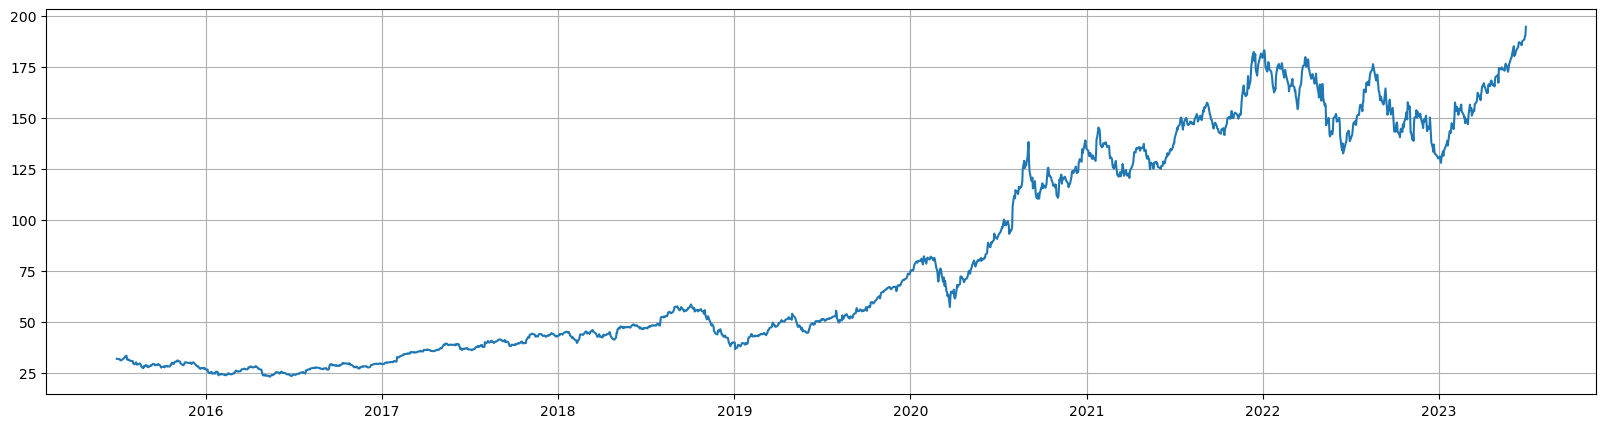

In [5]:
plt.figure(figsize=(20,5))
plt.plot(df_g.High)
plt.grid()

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing values
ser = df_g.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [7]:
int(series.shape[0]*0.9)

1812

In [8]:
# fixed input size to model, last 30 days
Window = 30
Predday = 7

# To split the data into 90:10
Trainsplit = 0.9

cut = int(series.shape[0]*Trainsplit)

# train
closetrain = series[:cut]
# test
closetest = series[cut:-(Window+Predday)]
# forecast for future 7 days
closeforecast = series[-(Window+Predday):]

closetrain.shape, closetest.shape , closeforecast.shape

((1812, 1), (165, 1), (37, 1))

In [9]:
def windowed_dataset(series, window_size = 31,predday = 7, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-7], tf.squeeze(w[-7:])))
    return ds.batch(batch_size).prefetch(3)

trainbatches =  windowed_dataset(closetrain)
testbatches =  windowed_dataset(closetest,batch_size=8)


In [10]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [11]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(7)
np.random.seed(7)

model = tf.keras.Sequential()
model.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model.add(layers.LSTM(j, return_sequences=True))
model.add(layers.LSTM(128))
for i in [64,64,7]:
    model.add(layers.Dense(i, activation="selu"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h = model.fit(trainbatches,epochs=100,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/100
56/56 [==============================] - 10s 91ms/step - loss: 9.2611e-04 - mse: 0.0019 - val_loss: 7.2461e-04 - val_mse: 0.0014
Epoch 2/100
56/56 [==============================] - 5s 94ms/step - loss: 4.9955e-04 - mse: 9.9911e-04 - val_loss: 6.9722e-04 - val_mse: 0.0014
Epoch 3/100
56/56 [==============================] - 5s 89ms/step - loss: 4.1868e-04 - mse: 8.3736e-04 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 4/100
56/56 [==============================] - 5s 92ms/step - loss: 3.7188e-04 - mse: 7.4376e-04 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 5/100
56/56 [==============================] - 5s 87ms/step - loss: 2.8400e-04 - mse: 5.6801e-04 - val_loss: 5.5851e-04 - val_mse: 0.0011
Epoch 6/100
56/56 [==============================] - 5s 94ms/step - loss: 2.5953e-04 - mse: 5.1907e-04 - val_loss: 8.6817e-04 - val_mse: 0.0017
Epoch 7/100
56/56 [==============================] - 5s 86ms/step - loss: 4.4708e-04 - mse: 8.9417e-04 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 8

In [13]:
for t in hist.keys():
    print(t)

loss
mse
val_loss
val_mse


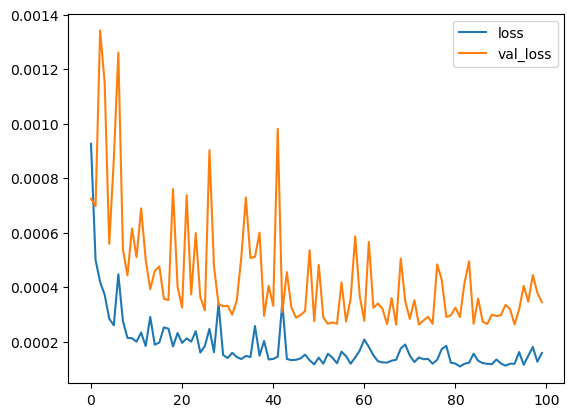

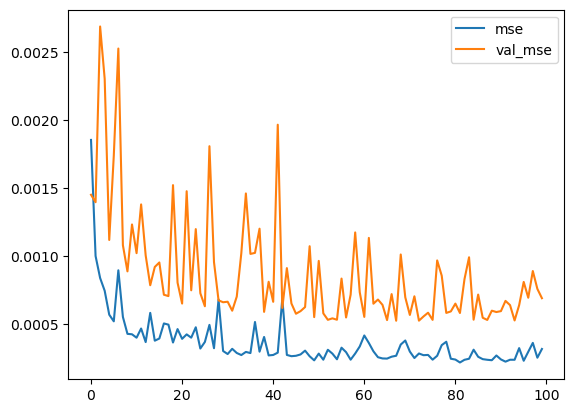

In [14]:
for i in ["loss","mse"]:
    plt.plot(hist[i],label = i)
    plt.plot(hist["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()


In [15]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

1/1 [==============================] - 1s 711ms/step


(8, 7)

In [16]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

1/1 [==============================] - 0s 30ms/step


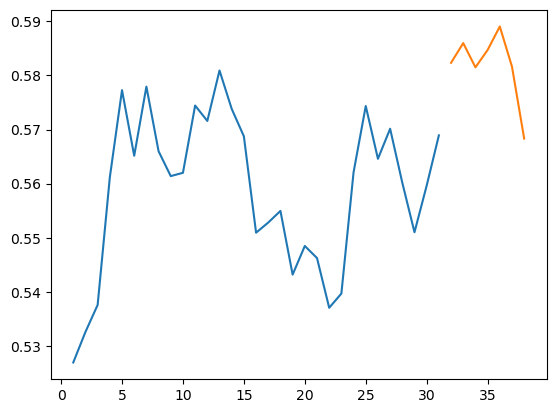

In [17]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)

time=list(range(1,32))
time2=list(range(32,39))
plt.plot(time,x1[0])
plt.plot(time2,output[0])

1/1 [==============================] - 0s 27ms/step


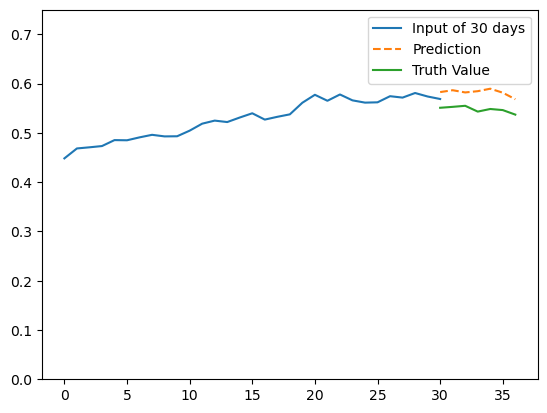

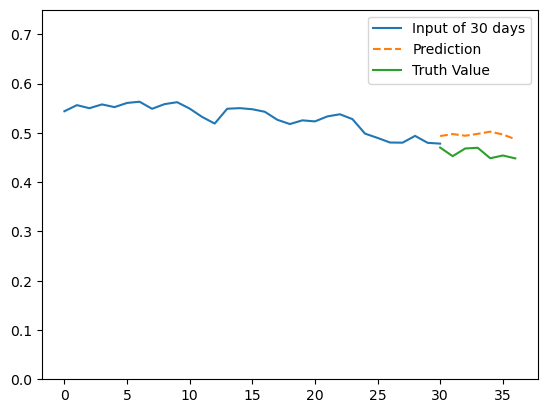

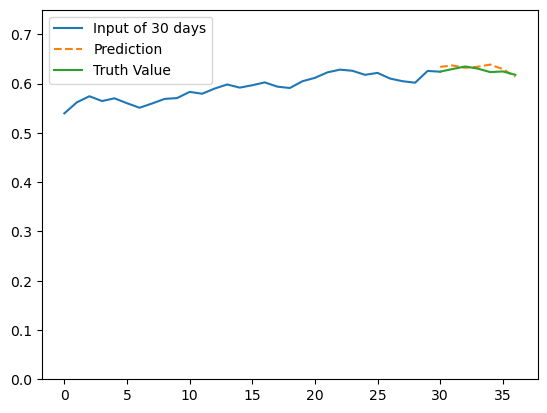

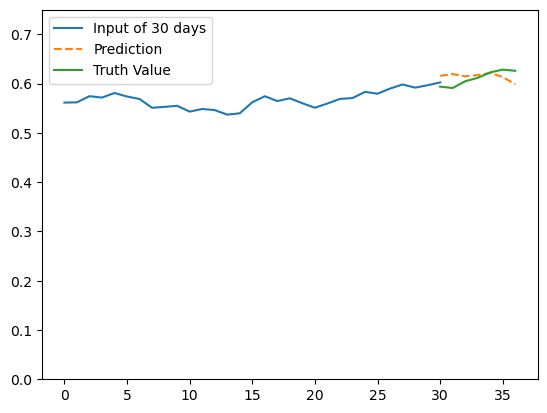

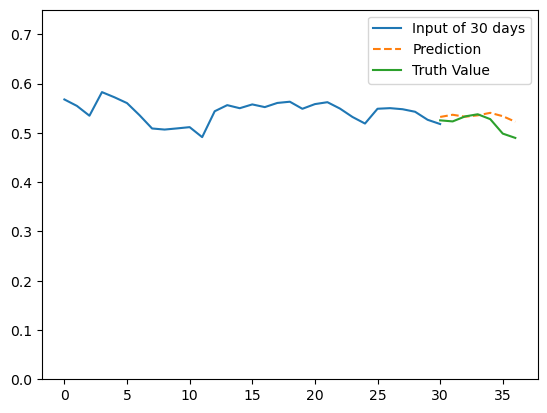

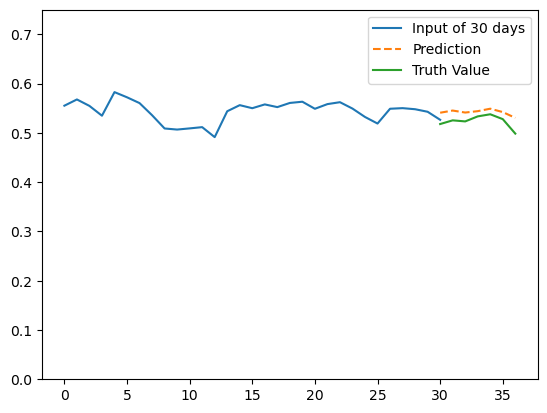

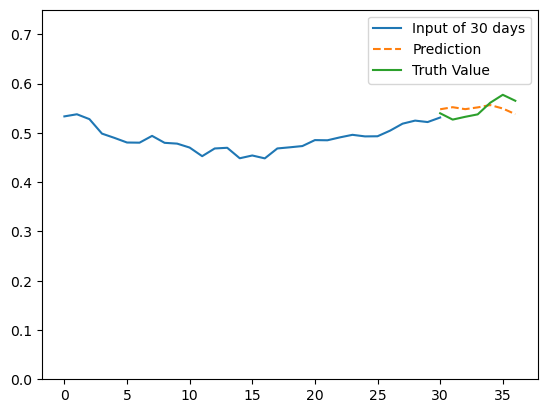

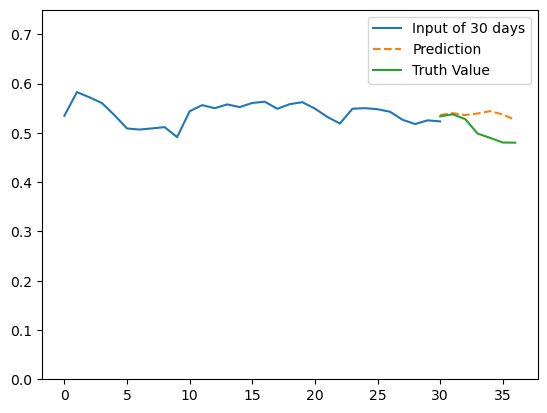

In [18]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [19]:
model.evaluate(testbatches)

16/16 [==============================] - 0s 7ms/step - loss: 3.4454e-04 - mse: 6.8908e-04


[0.0003445388865657151, 0.0006890777731314301]

1/1 [==============================] - 0s 25ms/step


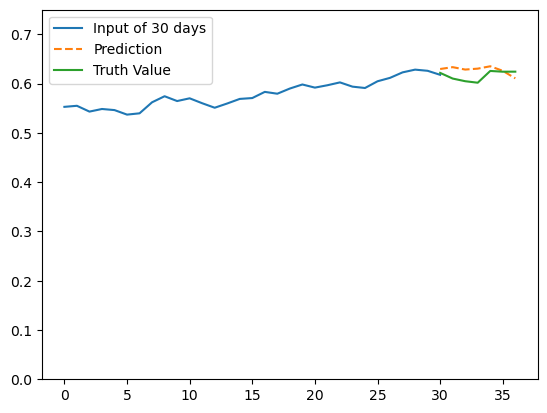

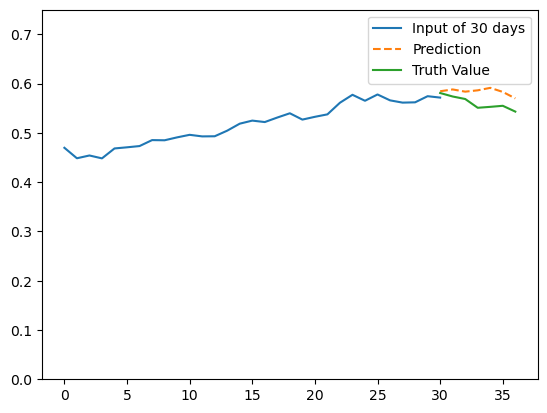

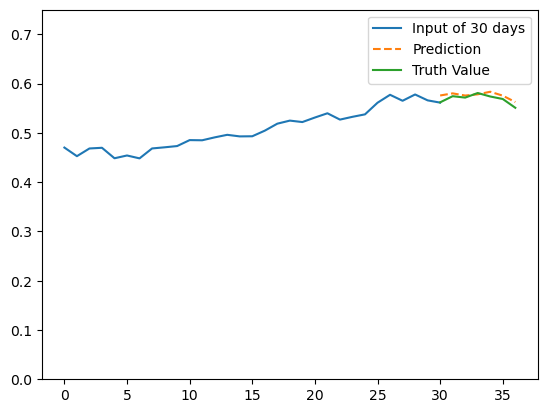

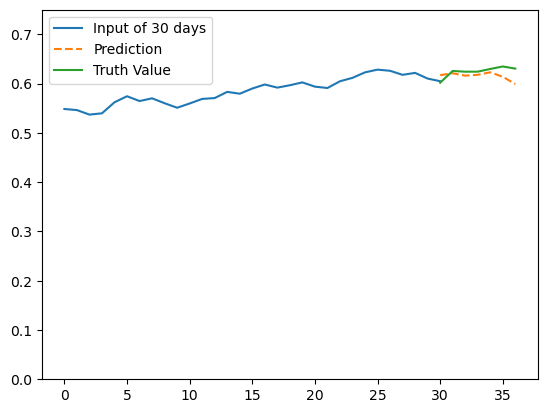

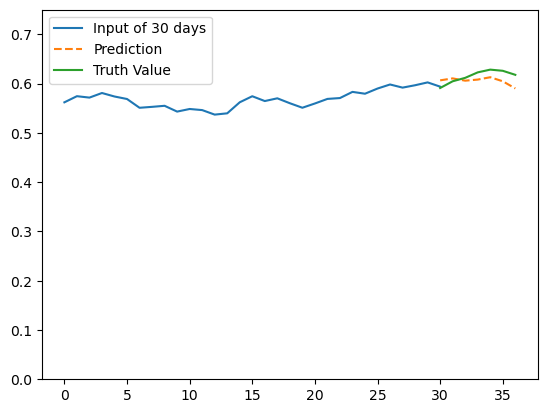

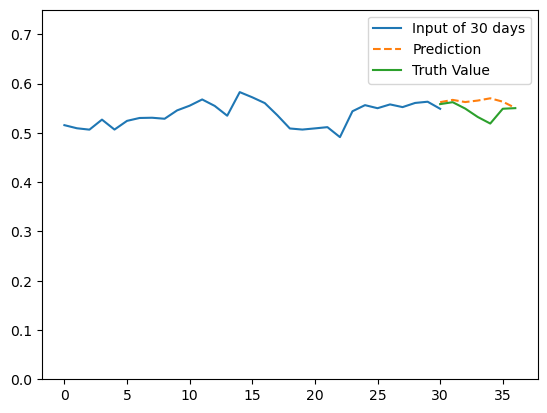

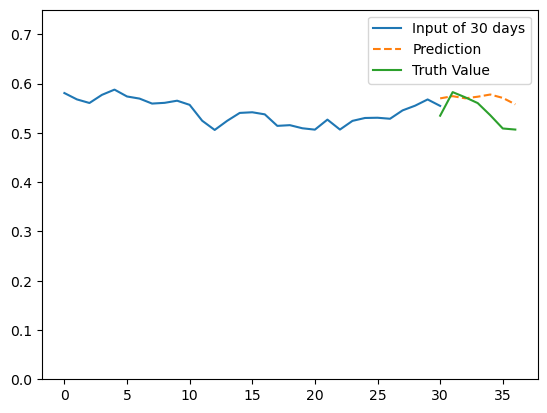

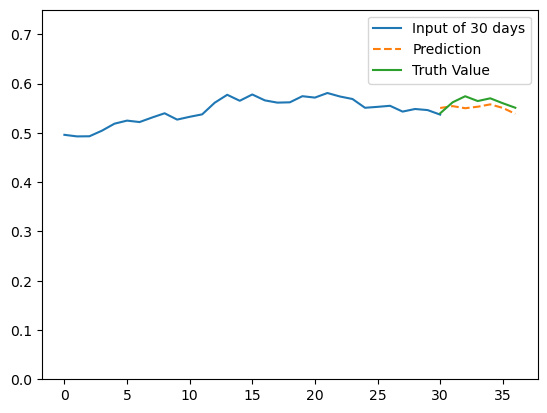

In [20]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [21]:
df_test=yf.download('GOOGL', start='2021-07-01', end='2023-07-01')

[*********************100%%**********************]  1 of 1 completed


In [22]:
len(df_test)

503

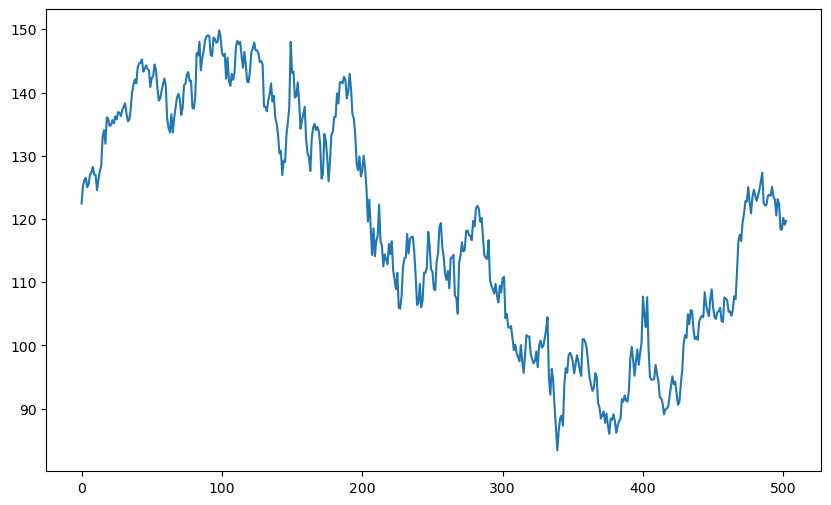

In [23]:
new_time_step=[]
for i in range(df_test.shape[0]):
    new_time_step.append(i)

close_data=df_test['Close']
new_time = np.array(new_time_step)
plt.figure(figsize=(10, 6))
plt.plot(new_time,close_data)

In [24]:
x_test=close_data
x_test=np.array(x_test).reshape(-1,1)

In [25]:
scaler1=MinMaxScaler(feature_range=(0,0.75))
xt1=scaler1.fit_transform(x_test)
xt1

array([[0.44061946],
       [0.47238869],
       [0.48292013],
       [0.48612751],
       [0.46997747],
       [0.47533637],
       [0.49179135],
       [0.49592483],
       [0.50603837],
       [0.49212446],
       [0.49172923],
       [0.46471463],
       [0.48314036],
       [0.49826833],
       [0.508122  ],
       [0.55999983],
       [0.57151949],
       [0.54740726],
       [0.59477318],
       [0.59119874],
       [0.57932908],
       [0.58077475],
       [0.58953301],
       [0.58383531],
       [0.59655196],
       [0.59075827],
       [0.60402276],
       [0.60282576],
       [0.59686267],
       [0.60719636],
       [0.61322149],
       [0.61979445],
       [0.60118243],
       [0.58748885],
       [0.59009756],
       [0.60985608],
       [0.63935531],
       [0.65313368],
       [0.66236619],
       [0.65515527],
       [0.68410667],
       [0.69073047],
       [0.69193884],
       [0.69778905],
       [0.67600911],
       [0.68111952],
       [0.68722944],
       [0.680

In [26]:
xt332=windowed_dataset(xt1)

1/1 [==============================] - 0s 30ms/step


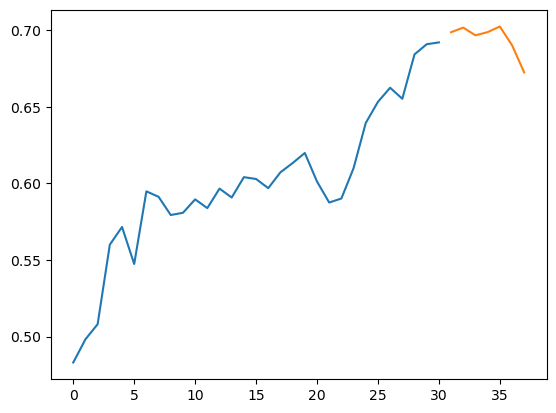

In [27]:
a,b=next(iter(xt332))
p=model.predict(a)
plt.plot(np.arange(0,31),a[0])
plt.plot(np.arange(31,38),p[0])

In [28]:
model.save('Model1_pred_7days.h5')

c:\Users\djsma\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
#Model 2:
def windowed_dataset1(series, window_size = 62,predday = 14, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-14], tf.squeeze(w[-14:])))
    return ds.batch(batch_size).prefetch(3)

train2batches =  windowed_dataset1(closetrain)
test2batches =  windowed_dataset1(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(14)
np.random.seed(14)

model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model2.add(layers.LSTM(j, return_sequences=True))
model2.add(layers.LSTM(128))
for i in [64,64,14]:
    model2.add(layers.Dense(i, activation="selu"))

print(model2.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model2.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h1 = model2.fit(train2batches,epochs=20,validation_data=test2batches,verbose=1)
hist1 = h1.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 14)                9

None
Epoch 1/20
55/55 [==============================] - 15s 193ms/step - loss: 7.9419e-04 - mse: 0.0016 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 2/20
55/55 [==============================] - 9s 155ms/step - loss: 5.3929e-04 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 3/20
55/55 [==============================] - 9s 154ms/step - loss: 3.9625e-04 - mse: 7.9249e-04 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 4/20
55/55 [==============================] - 8s 147ms/step - loss: 3.5774e-04 - mse: 7.1549e-04 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 5/20
55/55 [==============================] - 8s 152ms/step - loss: 3.4776e-04 - mse: 6.9551e-04 - val_loss: 7.7083e-04 - val_mse: 0.0015
Epoch 6/20
55/55 [==============================] - 9s 154ms/step - loss: 4.3465e-04 - mse: 8.6931e-04 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 7/20
55/55 [==============================] - 8s 151ms/step - loss: 4.1380e-04 - mse: 8.2761e-04 - val_loss: 8.4907e-04 - val_mse: 0.0017
Epoch 8/20
55/

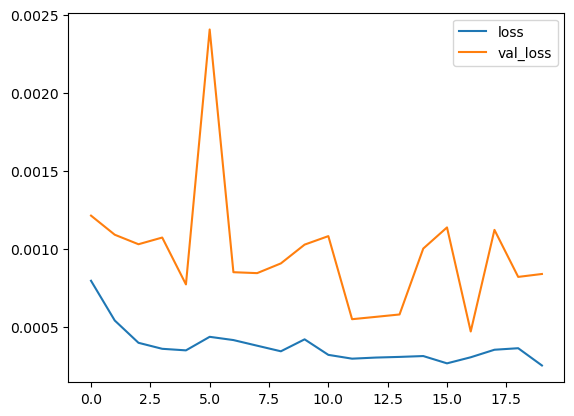

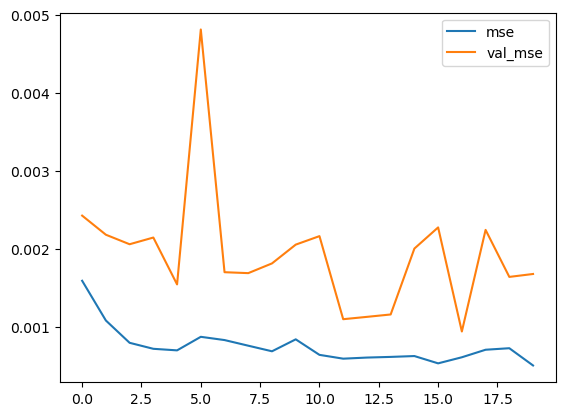

In [30]:
for i in ["loss","mse"]:
    plt.plot(hist1[i],label = i)
    plt.plot(hist1["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 693ms/step


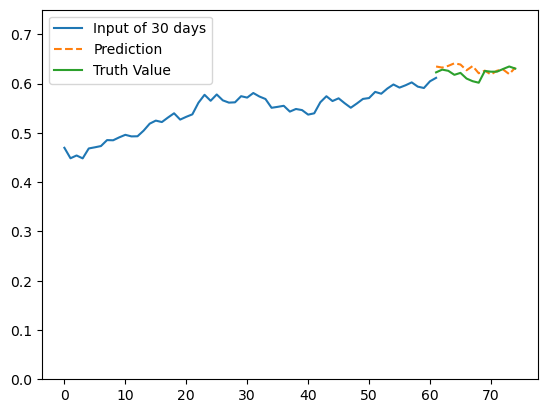

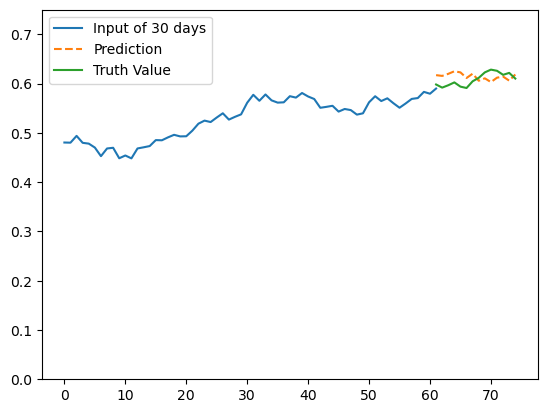

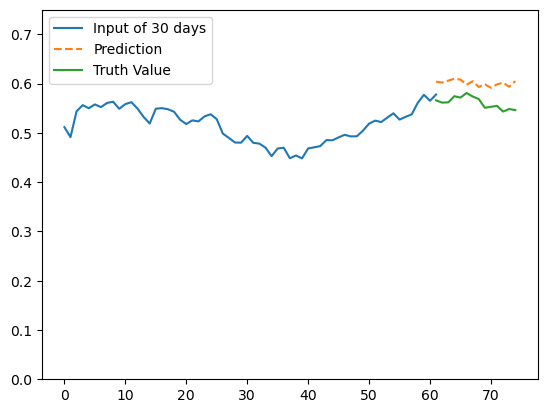

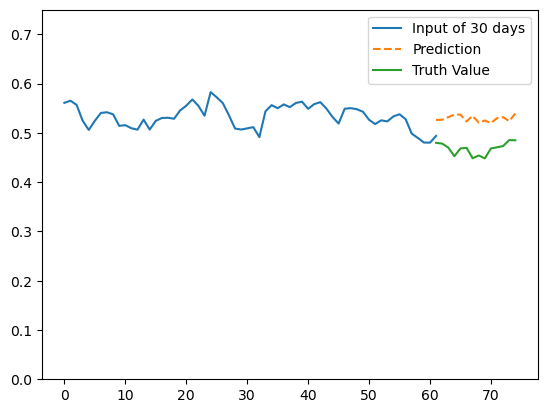

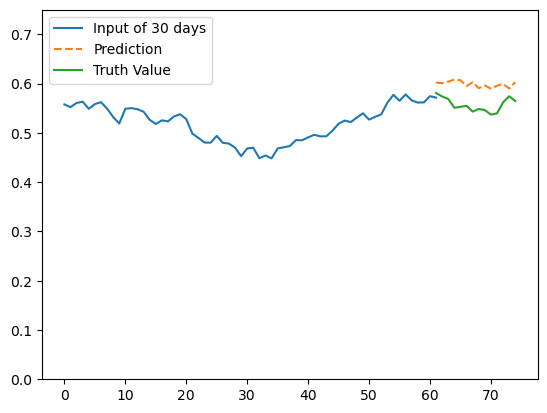

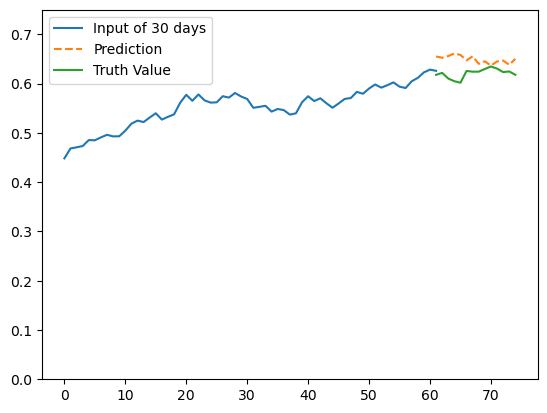

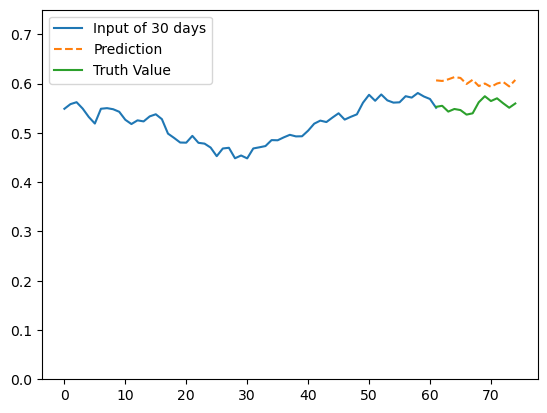

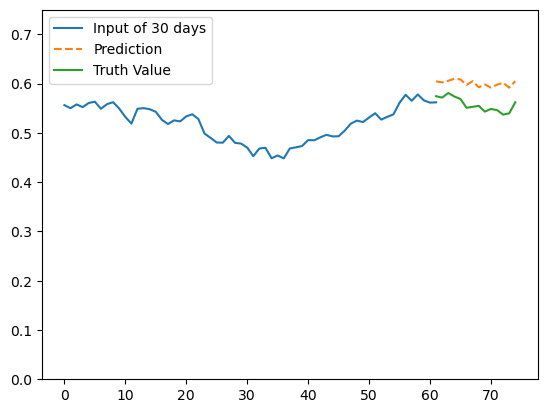

In [31]:
def visualplotloss2(dataset):
    x,y = next(iter(dataset))
    output = model2.predict(x)
    timecorr =list(range(61,75))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss2(test2batches)

1/1 [==============================] - 0s 32ms/step


Text(0.5, 1.0, 'Prediction for 14 Days')

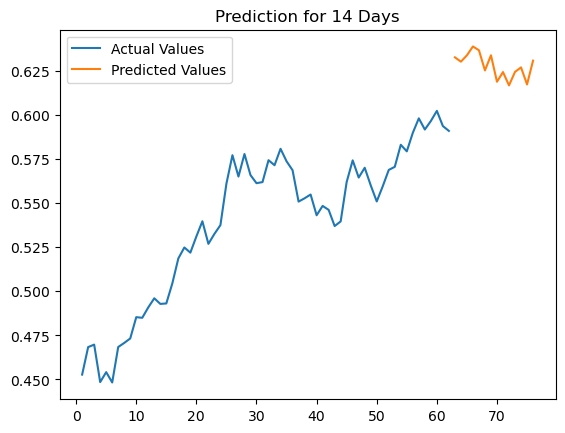

In [32]:
x2,y2 = next(iter(test2batches))
output2 = model2.predict(x2)

time=list(range(1,63))
time2=list(range(63,77))
plt.plot(time,x2[0])
plt.plot(time2,output2[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 14 Days')

In [33]:
model2.save('Model2_pred_14days.h5')

In [34]:
#Model 3:
def windowed_dataset2(series, window_size = 90,predday = 21, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-21], tf.squeeze(w[-21:])))
    return ds.batch(batch_size).prefetch(3)

train3batches =  windowed_dataset2(closetrain)
test3batches =  windowed_dataset2(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(21)
np.random.seed(21)

model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model3.add(layers.LSTM(j, return_sequences=True))
model3.add(layers.LSTM(128))
for i in [64,64,21]:
    model3.add(layers.Dense(i, activation="selu"))

print(model3.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model3.compile(optimizer = 'adam', loss ='mse', metrics=["mse"])
h2 = model3.fit(train3batches,epochs=30,validation_data=test3batches,verbose=1)
hist2 = h2.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 21)                1

None
Epoch 1/30
54/54 [==============================] - 15s 212ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 9.4470e-04 - val_mse: 9.4470e-04
Epoch 2/30
54/54 [==============================] - 12s 220ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/30
54/54 [==============================] - 12s 218ms/step - loss: 9.7036e-04 - mse: 9.7036e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/30
54/54 [==============================] - 12s 219ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 5/30
54/54 [==============================] - 12s 221ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9.9318e-04 - val_mse: 9.9318e-04
Epoch 6/30
54/54 [==============================] - 12s 219ms/step - loss: 8.7125e-04 - mse: 8.7125e-04 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 7/30
54/54 [==============================] - 12s 216ms/step - loss: 8.6600e-04 - mse: 8.6600e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/30
54/54 [======

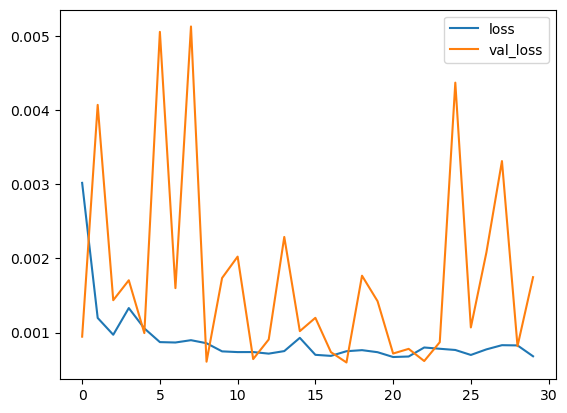

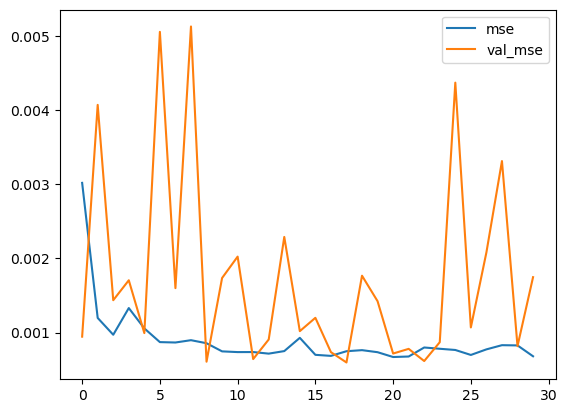

In [35]:
for i in ["loss","mse"]:
    plt.plot(hist2[i],label = i)
    plt.plot(hist2["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 718ms/step


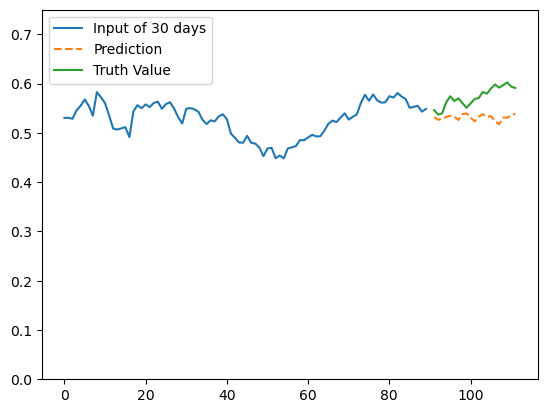

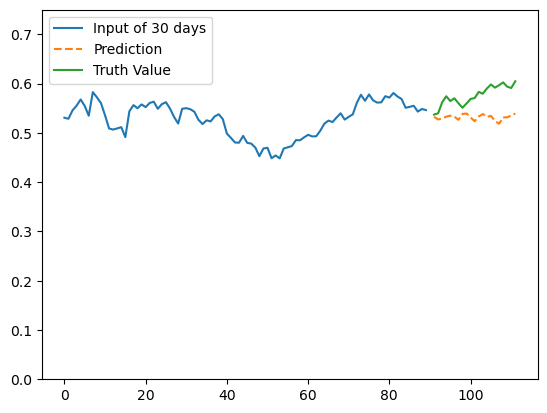

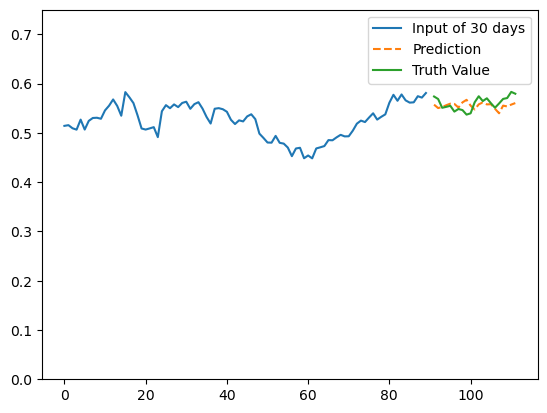

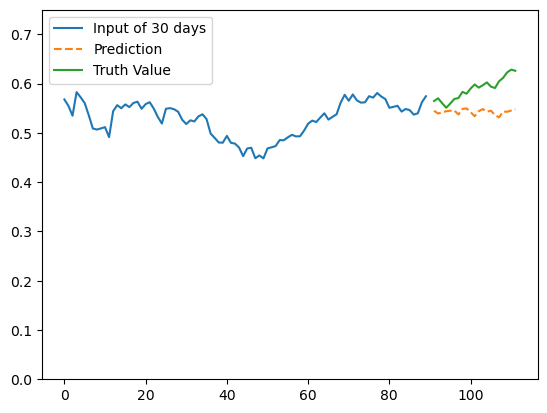

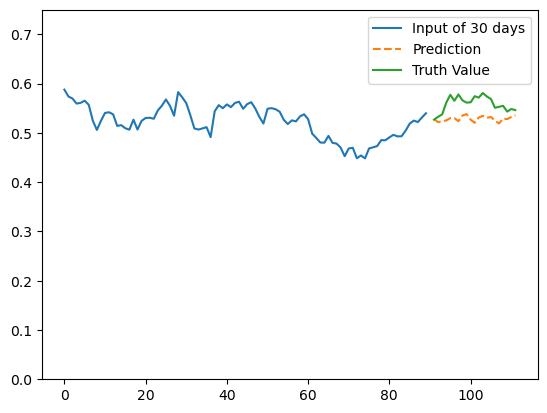

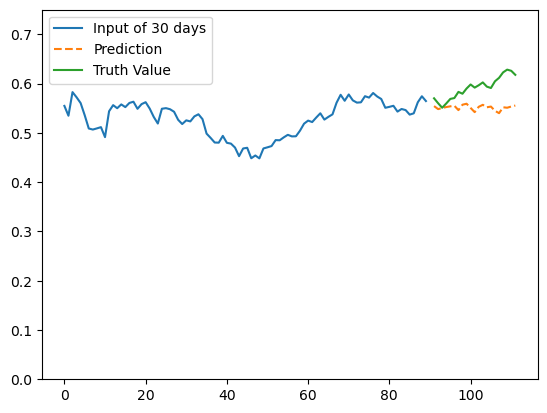

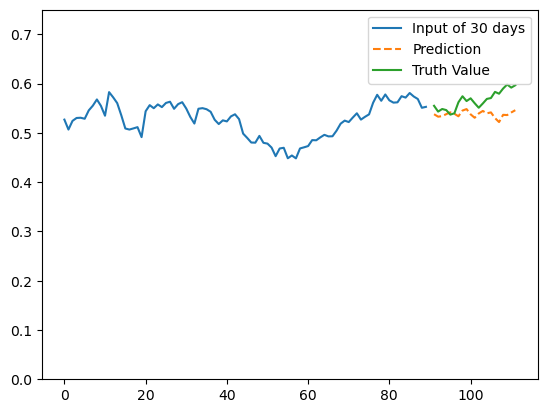

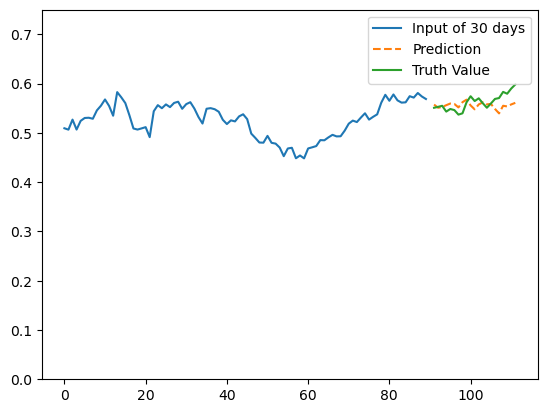

In [36]:
def visualplotloss3(dataset):
    x,y = next(iter(dataset))
    output = model3.predict(x)
    timecorr =list(range(91,112))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss3(test3batches)

1/1 [==============================] - 0s 32ms/step


Text(0.5, 1.0, 'Prediction for 21 Days')

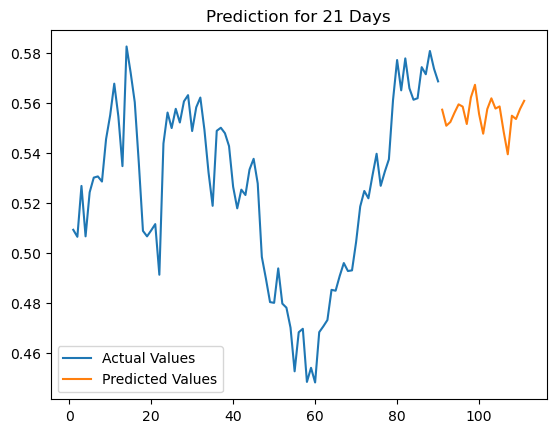

In [37]:
x3,y3 = next(iter(test3batches))
output3 = model3.predict(x3)

time=list(range(1,91))
time2=list(range(91,112))
plt.plot(time,x3[0])
plt.plot(time2,output3[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 21 Days')

In [38]:
model3.save('Model_3_Pred21_Days.h5')

In [39]:
#Model 4:
def windowed_dataset3(series, window_size = 120,predday = 28, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-28], tf.squeeze(w[-28:])))
    return ds.batch(batch_size).prefetch(3)

train4batches =  windowed_dataset3(closetrain)
test4batches =  windowed_dataset3(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(28)
np.random.seed(28)

model4 = tf.keras.Sequential()
model4.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model4.add(layers.LSTM(j, return_sequences=True))
model4.add(layers.LSTM(128))
for i in [64,64,28]:
    model4.add(layers.Dense(i, activation="selu"))

print(model4.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model4.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h3 = model4.fit(train4batches,epochs=20,validation_data=test4batches,verbose=1)
hist3 = h3.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 28)                1

None
Epoch 1/20
53/53 [==============================] - 22s 342ms/step - loss: 0.0015 - mse: 0.0029 - val_loss: 0.0056 - val_mse: 0.0112
Epoch 2/20
53/53 [==============================] - 17s 321ms/step - loss: 6.4924e-04 - mse: 0.0013 - val_loss: 0.0019 - val_mse: 0.0037
Epoch 3/20
53/53 [==============================] - 16s 307ms/step - loss: 6.7020e-04 - mse: 0.0013 - val_loss: 0.0121 - val_mse: 0.0242
Epoch 4/20
53/53 [==============================] - 16s 306ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 6.5921e-04 - val_mse: 0.0013
Epoch 5/20
53/53 [==============================] - 17s 319ms/step - loss: 6.3983e-04 - mse: 0.0013 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 6/20
53/53 [==============================] - 16s 297ms/step - loss: 6.0108e-04 - mse: 0.0012 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 7/20
53/53 [==============================] - 16s 294ms/step - loss: 6.0497e-04 - mse: 0.0012 - val_loss: 0.0063 - val_mse: 0.0126
Epoch 8/20
53/53 [======================

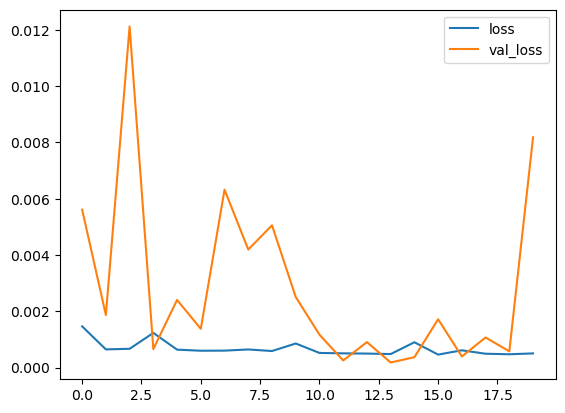

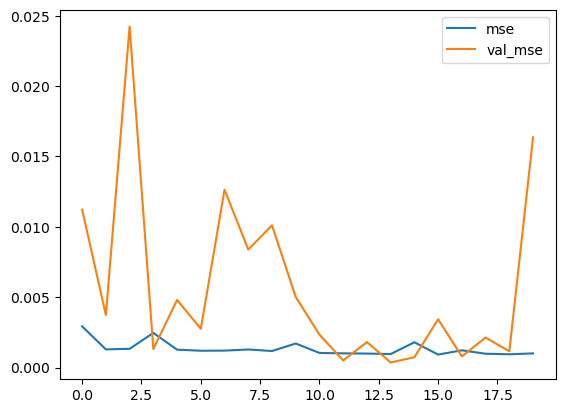

In [40]:
for i in ["loss","mse"]:
    plt.plot(hist3[i],label = i)
    plt.plot(hist3["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 749ms/step


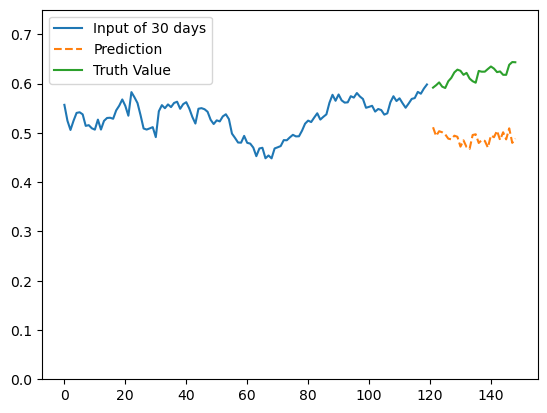

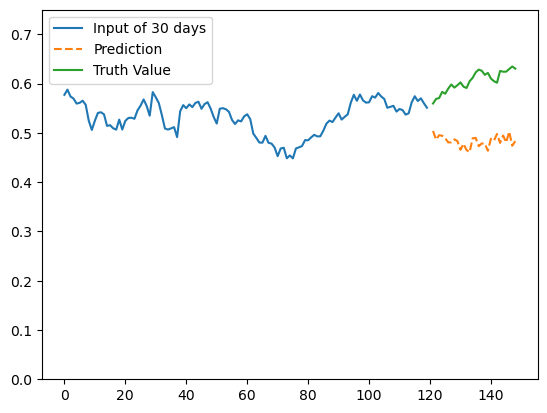

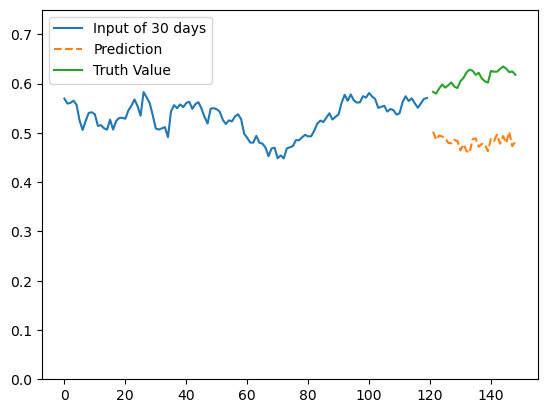

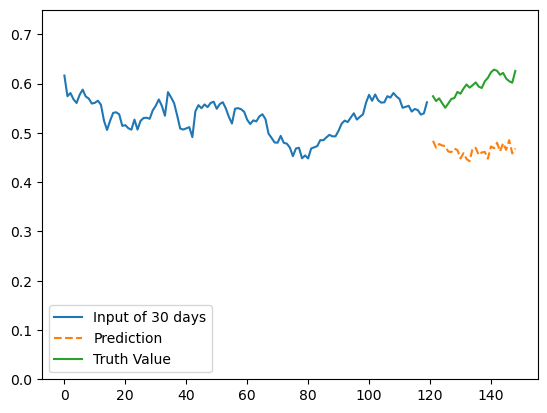

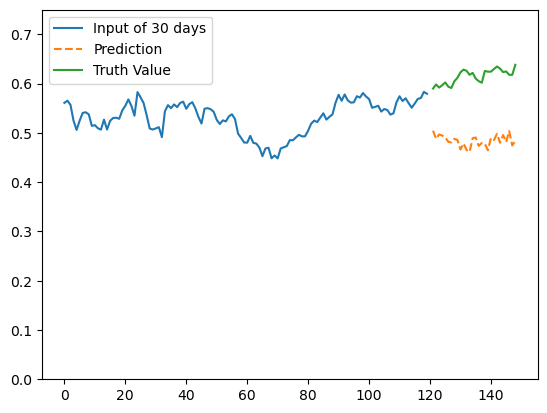

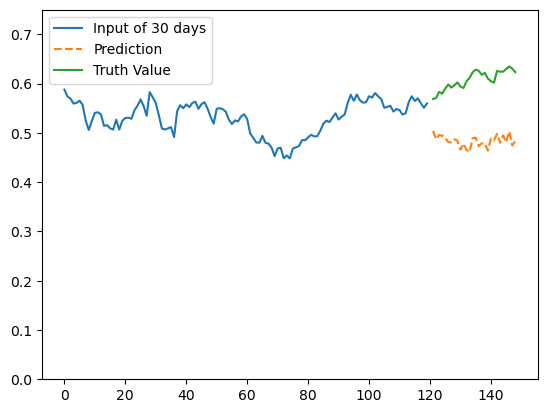

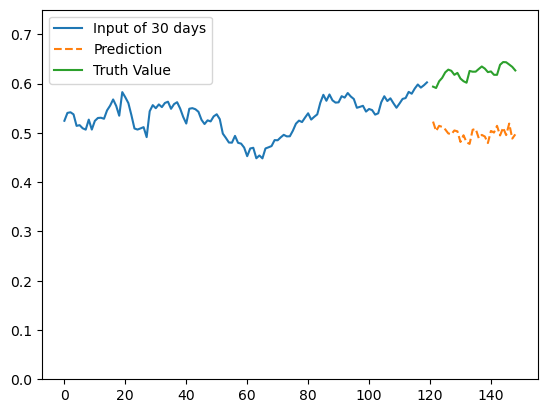

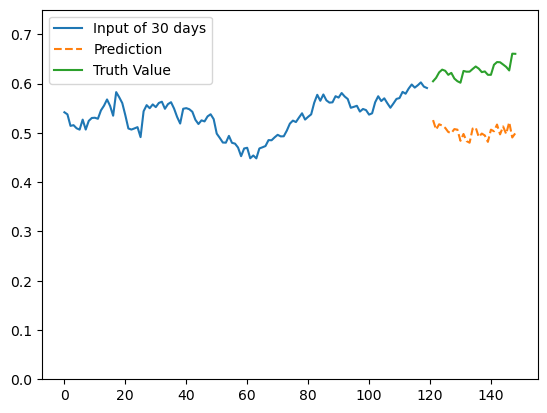

In [41]:
def visualplotloss4(dataset):
    x,y = next(iter(dataset))
    output = model4.predict(x)
    timecorr =list(range(121,149))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss4(test4batches)

1/1 [==============================] - 0s 38ms/step


Text(0.5, 1.0, 'Prediction for 28 Days')

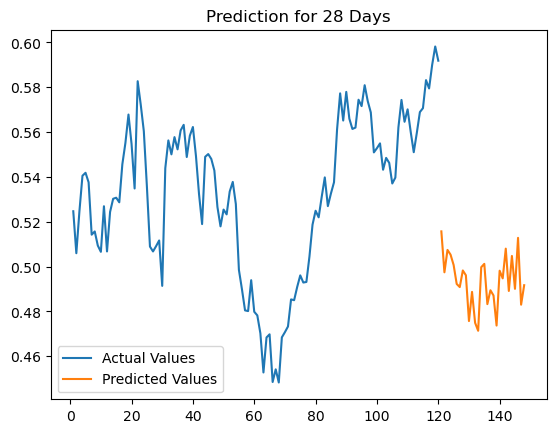

In [42]:
x4,y4 = next(iter(test4batches))
output4 = model4.predict(x4)

time=list(range(1,121))
time2=list(range(121,149))
plt.plot(time,x4[0])
plt.plot(time2,output4[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 28 Days')

In [43]:
model4.save('Model_4_Pred28_Days.h5')

In [47]:
#Model 5:
def windowed_dataset4(series, window_size = 150,predday = 35, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-35], tf.squeeze(w[-35:])))
    return ds.batch(batch_size).prefetch(3)

train5batches =  windowed_dataset4(closetrain)
test5batches =  windowed_dataset4(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(35)
np.random.seed(35)

model5 = tf.keras.Sequential()
model5.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model5.add(layers.LSTM(j, return_sequences=True))
model5.add(layers.LSTM(128))
for i in [64,64,35]:
    model5.add(layers.Dense(i, activation="selu"))

print(model5.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model5.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h4 = model5.fit(train5batches,epochs=15,validation_data=test5batches,verbose=1)
hist4 = h4.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 35)                2

None
Epoch 1/15
51/51 [==============================] - 18s 272ms/step - loss: 0.0018 - mse: 0.0037
Epoch 2/15
51/51 [==============================] - 18s 349ms/step - loss: 7.0400e-04 - mse: 0.0014
Epoch 3/15
51/51 [==============================] - 19s 374ms/step - loss: 7.5717e-04 - mse: 0.0015
Epoch 4/15
51/51 [==============================] - 19s 366ms/step - loss: 7.0464e-04 - mse: 0.0014
Epoch 5/15
51/51 [==============================] - 19s 377ms/step - loss: 8.1434e-04 - mse: 0.0016
Epoch 6/15
51/51 [==============================] - 19s 372ms/step - loss: 7.1420e-04 - mse: 0.0014
Epoch 7/15
51/51 [==============================] - 19s 369ms/step - loss: 6.6640e-04 - mse: 0.0013
Epoch 8/15
51/51 [==============================] - 18s 353ms/step - loss: 6.3990e-04 - mse: 0.0013
Epoch 9/15
51/51 [==============================] - 18s 353ms/step - loss: 6.9732e-04 - mse: 0.0014
Epoch 10/15
51/51 [==============================] - 19s 365ms/step - loss: 6.6193e-04 - mse: 0.001

KeyError: 'val_loss'

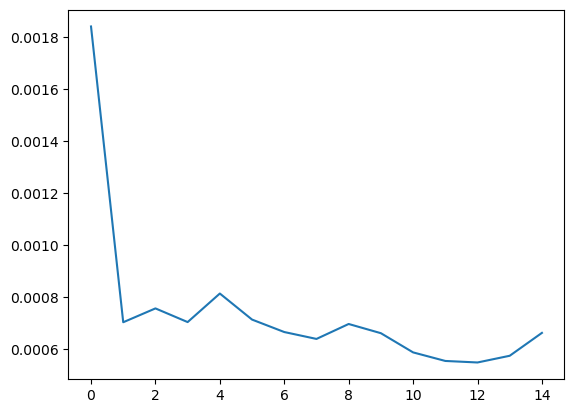

In [49]:
for i in ["loss","mse"]:
    plt.plot(hist4[i],label = i)
    plt.plot(hist4["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

In [ ]:
def visualplotloss5(dataset):
    x,y = next(iter(dataset))
    output = model5.predict(x)
    timecorr =list(range(151,186))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss5(test5batches)

StopIteration: 

In [ ]:
x5,y5 = next(iter(test5batches))
output5 = model5.predict(x5)

time=list(range(1,151))
time2=list(range(151,186))
plt.plot(time,x5[0])
plt.plot(time2,output5[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 35 Days')

StopIteration: 

In [ ]:
model5.save('Model5_Pred_35Days.h5')